chemLTD WT vs. mutant
=====================

Two florophore (CFP + EYFP) data analysis. Two emission channels (DX505) + two excitation wls. (435 nm + 505 nm)

In [1]:
import os
import sys
import glob
import yaml

import numpy as np
from numpy import ma
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as anm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap

import plotly.express as px

from skimage.util import montage
from skimage.filters import rank
from skimage import morphology
from skimage import exposure
from skimage import measure
from skimage import filters
from skimage import io

from scipy import ndimage
from scipy import signal
from scipy import stats


### Cmaps

In [2]:
# CFP cmap
dict_cyan = {'red':(
             (0.0, 0.0, 0.0),
             (1.0, 0.0, 0.0)),
             'blue':(
             (0.0, 0.0, 0.0),
             (1.0, 1.0, 1.0)),
             'green':(
             (0.0, 0.0, 0.0),
             (1.0, 1.0, 1.0))}
cmap_cyan = LinearSegmentedColormap('Cyan', dict_cyan)

# YFP cmap
dict_yellow = {'red':(
               (0.0, 0.0, 0.0),
               (1.0, 1.0, 1.0)),
               'blue':(
               (0.0, 0.0, 0.0),
               (1.0, 0.0, 0.0)),
               'green':(
               (0.0, 0.0, 0.0),
               (1.0, 1.0, 1.0))}
cmap_yellow = LinearSegmentedColormap('Yellow', dict_yellow)

# red-green cmap creation
dict_red_green = {'red':(
                   (0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (0.55, 0.3, 0.7),
                   (1.0, 1.0, 1.0)),
                   'blue':(
                   (0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),
                   'green':(
                   (0.0, 1.0, 1.0),
                   (0.45, 0.7, 0.3),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))}
cmap_red_green = LinearSegmentedColormap('RedGreen', dict_red_green)

# only red cmap
dict_red = {'red':(
             (0.0, 1.0, 1.0),
             (1.0, 1.0, 0.0)),
             'blue':(
             (0.0, 0.0, 0.0),
             (1.0, 0.0, 0.0)),
             'green':(
             (0.0, 0.0, 0.0),
             (1.0, 0.0, 0.0))}
cmap_red = LinearSegmentedColormap('red', dict_red)


def plot_linearmap(cdict):
    newcmp = LinearSegmentedColormap('testCmap', segmentdata=cdict, N=256)
    rgba = newcmp(np.linspace(0, 1, 256))
    fig, ax = plt.subplots(figsize=(4, 3), constrained_layout=True)
    col = ['r', 'g', 'b']
    for xx in [0.25, 0.5, 0.75]:
        ax.axvline(xx, color='0.7', linestyle='--')
    for i in range(3):
        ax.plot(np.arange(256)/256, rgba[:, i], color=col[i])
    ax.set_xlabel('index')
    ax.set_ylabel('RGB')
    plt.show()
# plot_linearmap(dict_red)

## Img upload

#### Channels define

(50, 1040, 696, 4)


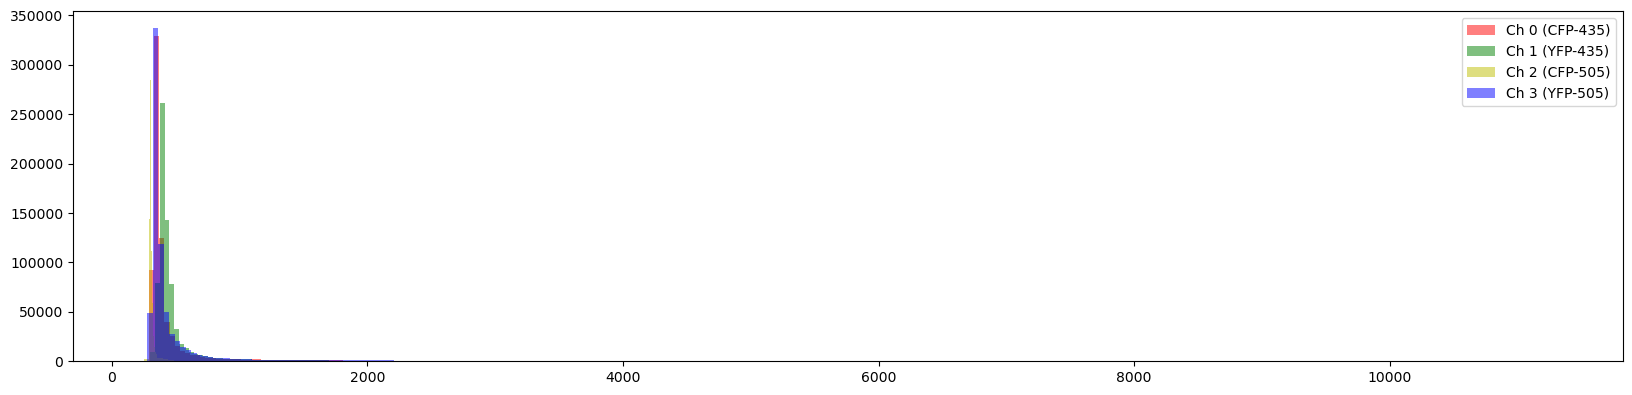

In [88]:
img_raw = io.imread('11.tif')
print(img_raw.shape)

img_cfp_raw = img_raw[:,:,:,0]  # 2
img_yfp_raw = img_raw[:,:,:,3]  # 1

ch0_ctrl = np.mean(img_raw[:,:,:,0], axis=0)
# ch0_ctrl = ch0_ctrl / ch0_ctrl.max()
ch1_ctrl = np.mean(img_raw[:,:,:,1], axis=0)
# ch1_ctrl = ch1_ctrl / ch1_ctrl.max()
ch2_ctrl = np.mean(img_raw[:,:,:,2], axis=0)
# ch2_ctrl = ch2_ctrl / ch2_ctrl.max()
ch3_ctrl = np.mean(img_raw[:,:,:,3], axis=0)
# ch3_ctrl = ch3_ctrl / ch3_ctrl.max()


plt.figure(figsize=(20,10))

ax0 = plt.subplot(211)
ax0.hist(ch0_ctrl.ravel(), bins=256, alpha=.5, label='Ch 0 (CFP-435)', color='r')
ax0.hist(ch1_ctrl.ravel(), bins=256, alpha=.5, label='Ch 1 (YFP-435)', color='g')
ax0.hist(ch2_ctrl.ravel(), bins=256, alpha=.5, label='Ch 2 (CFP-505)', color='y')
ax0.hist(ch3_ctrl.ravel(), bins=256, alpha=.5, label='Ch 3 (YFP-505)', color='b')
# ax0.set_xlim([250, 1500])
ax0.legend()

plt.show()

#### Channels review

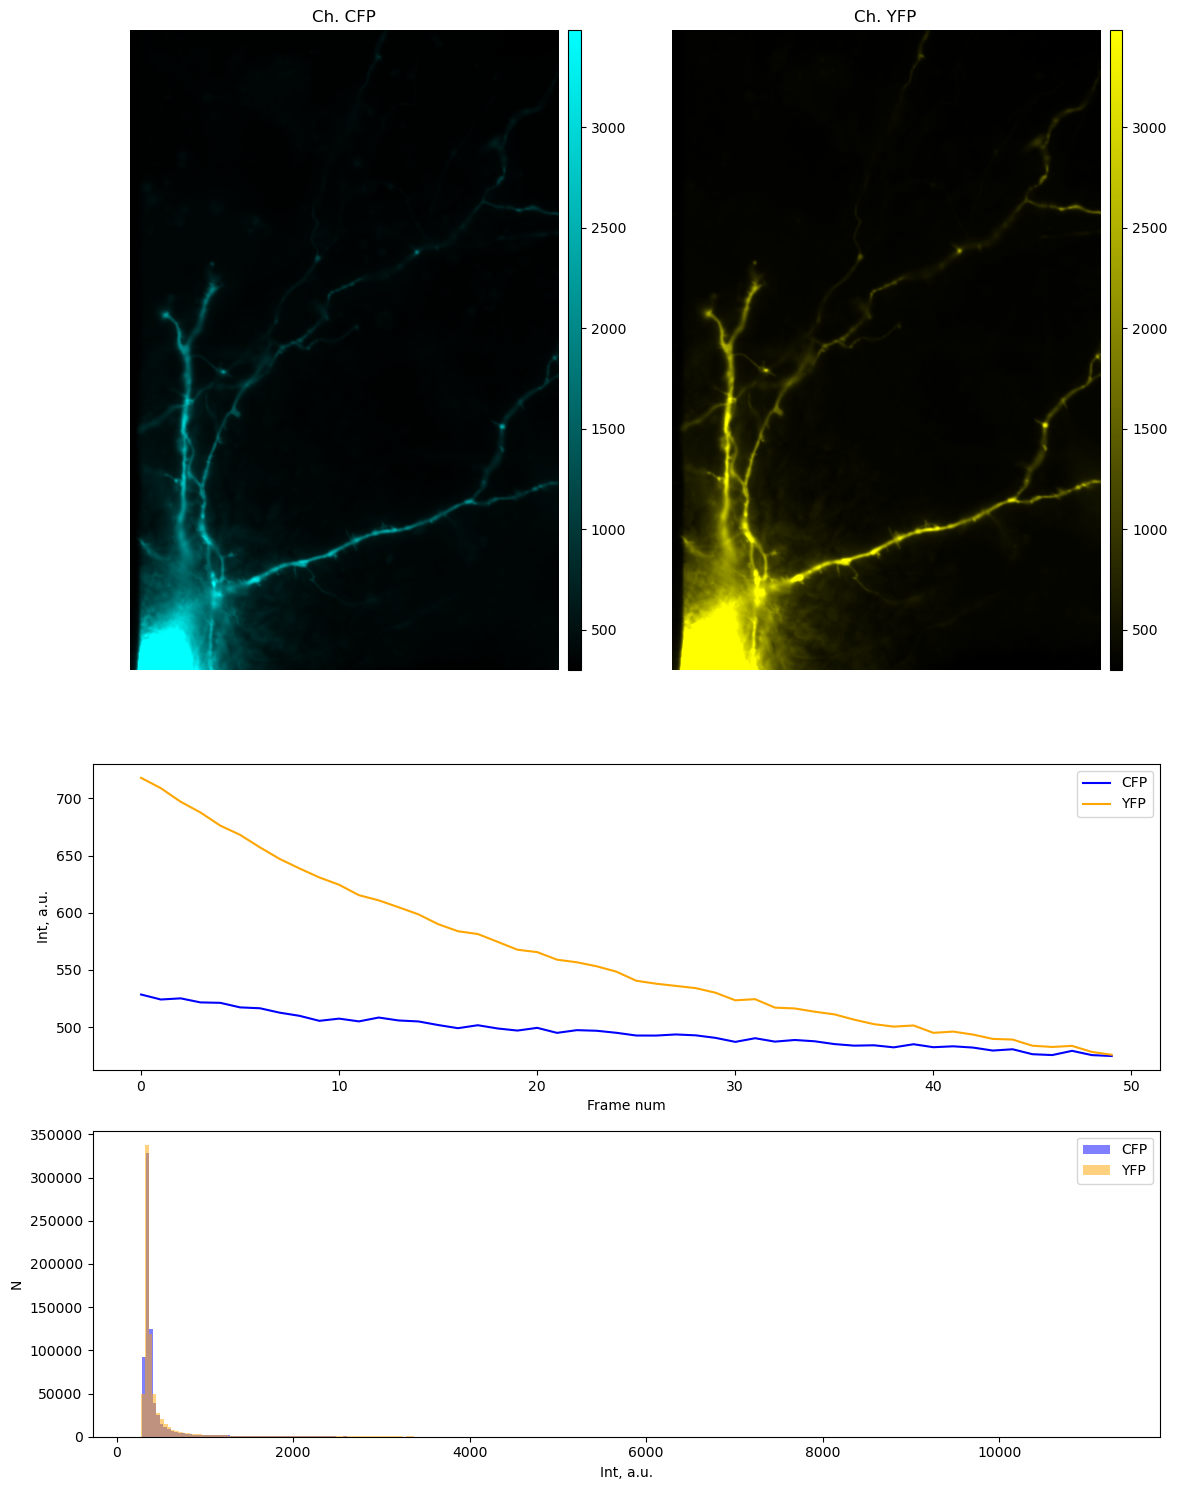

In [89]:
img_cfp_ctrl = np.mean(img_cfp_raw, axis=0)
img_yfp_ctrl = np.mean(img_yfp_raw, axis=0)

img_cfp = filters.gaussian(img_cfp_raw, sigma=0.5)
img_yfp = filters.gaussian(img_yfp_raw, sigma=0.5)


ctrl_img_int_min, ctrl_img_int_max = 300, np.max(img_raw)*0.3


plt.figure(figsize=(12,15))
ax0 = plt.subplot(221)
ax0.set_title('Ch. CFP')
img0 = ax0.imshow(img_cfp_ctrl, cmap=cmap_cyan)
img0.set_clim(vmin=ctrl_img_int_min, vmax=ctrl_img_int_max)
div0 = make_axes_locatable(ax0)
cax0 = div0.append_axes('right', size='3%', pad=0.1)
plt.colorbar(img0, cax=cax0)
ax0.axis('off')

ax1 = plt.subplot(222)
ax1.set_title('Ch. YFP')
img1 = ax1.imshow(img_yfp_ctrl, cmap=cmap_yellow)
img1.set_clim(vmin=ctrl_img_int_min, vmax=ctrl_img_int_max)
div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes('right', size='3%', pad=0.1)
plt.colorbar(img1, cax=cax1)
ax1.axis('off')

ax2 = plt.subplot(413)
ax2.plot(np.mean(img_cfp_raw, axis=(1,2)), label='CFP', color='blue')
ax2.plot(np.mean(img_yfp_raw, axis=(1,2)), label='YFP', color='orange')
ax2.set_xlabel('Frame num')
ax2.set_ylabel('Int, a.u.')
ax2.legend()

ax3 = plt.subplot(414)
ax3.hist(img_cfp_ctrl.ravel(), bins=256, alpha=.5, label='CFP', color='blue')
ax3.hist(img_yfp_ctrl.ravel(), bins=256, alpha=.5, label='YFP', color='orange')
ax3.set_xlabel('Int, a.u.')
ax3.set_ylabel('N')
ax3.legend()

plt.tight_layout()
plt.show()

## Masking and application frame detection

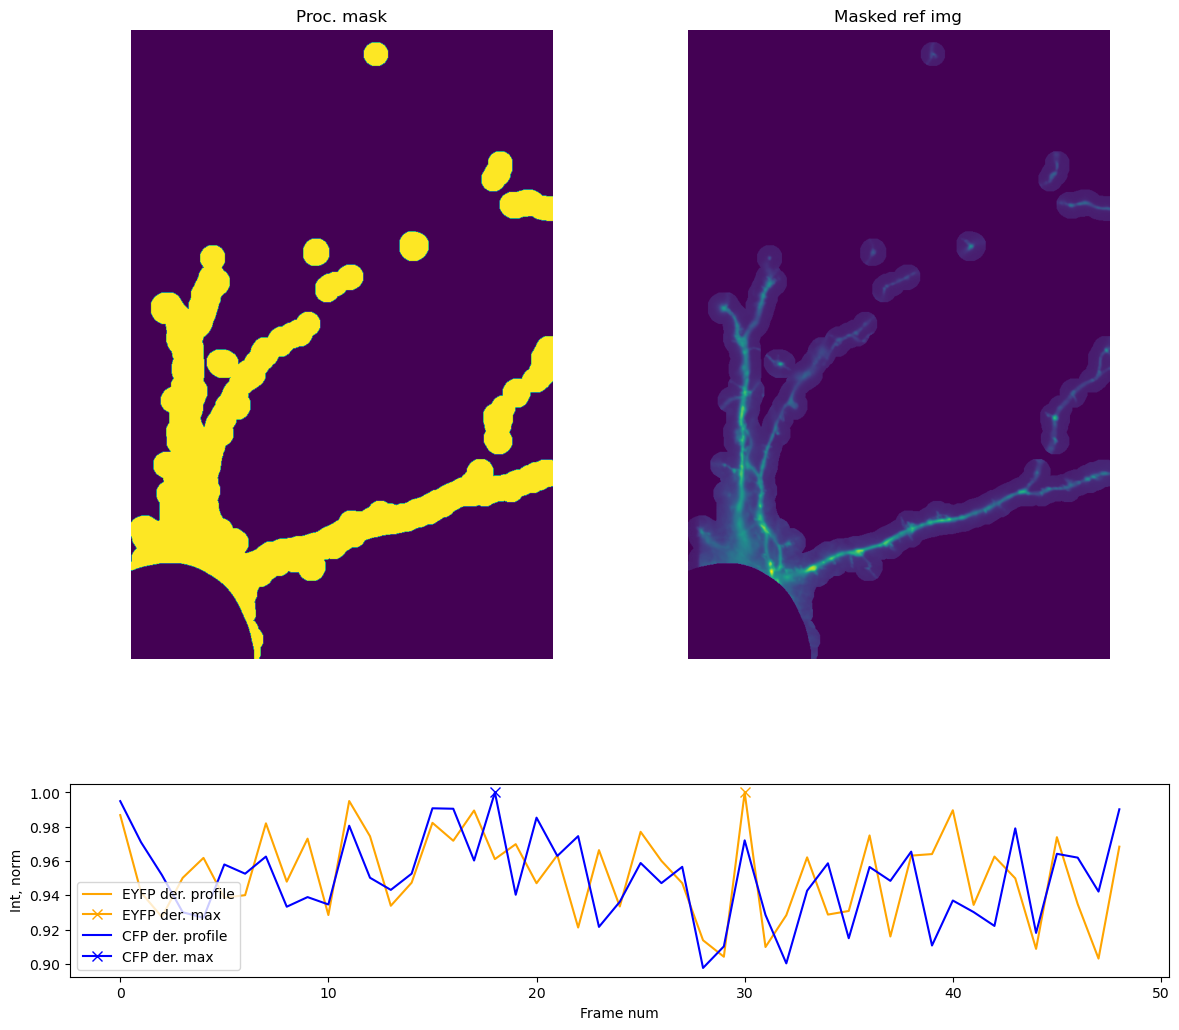

In [106]:
def cell_masking(input_img, soma_mask=True, soma_th=0.5, soma_ext=20, proc_ext=5):
    # soma masking
    if soma_mask:
        soma_region = np.copy(input_img)
        soma_region = soma_region > soma_region.max() * soma_th
        soma_region = morphology.opening(soma_region, footprint=morphology.disk(5))
        # soma_region = morphology.dilation(soma_region, footprint=morphology.disk(10))
        soma_dist = ndimage.distance_transform_edt(~soma_region, return_indices=False)
        soma_mask = soma_dist < soma_ext
        input_img = ma.masked_where(soma_mask, input_img)

        th = filters.threshold_otsu(input_img.compressed())
    else:
        th = filters.threshold_otsu(input_img)

    # processes masking
    proc_mask = input_img > th
    proc_mask = morphology.closing(proc_mask, footprint=morphology.disk(5))
    proc_dist = ndimage.distance_transform_edt(~proc_mask, return_indices=False)
    proc_mask_fin = proc_dist < proc_ext
    proc_mask_fin[soma_mask] = 0

    return proc_mask_fin

img_ctrl_max = np.max(img_yfp, axis=0)

mask = cell_masking(img_ctrl_max, soma_mask=True, soma_th=0.75, soma_ext=100, proc_ext=20)
mask_arr = np.asarray([z+mask for z in np.zeros_like(img_yfp)], dtype='bool')

# maskings
img_yfp_masked = np.copy(img_yfp)
img_yfp_masked[~mask_arr] = 0

img_cfp_masked = np.copy(img_cfp)
img_cfp_masked[~mask_arr] = 0

# pb corr with constant val
img_yfp_masked = np.asarray([img * (np.sum(np.mean(img_yfp_masked[:2], axis=0)/np.sum(img))) for img in img_yfp_masked])
img_cfp_masked = np.asarray([img * (np.sum(np.mean(img_cfp_masked[:2], axis=0)/np.sum(img))) for img in img_cfp_masked])


def der_prof_calc(input_img_series):
    input_series_mean_prof = np.mean(input_img_series, axis=(1, 2))
    input_series_mean_prof_norm = input_series_mean_prof / input_series_mean_prof.max()

    input_series_der_prof = np.asarray([np.sum(np.abs(img)) for img in (input_img_series[:-1] - input_img_series[1:])])
    input_series_der_prof_norm = input_series_der_prof / input_series_der_prof.max()

    der_max_idx = np.argmax(input_series_der_prof_norm)

    return input_series_der_prof_norm, der_max_idx

yfp_der_prof, yfp_der_max = der_prof_calc(img_yfp_masked)
cfp_der_prof, cfp_der_max = der_prof_calc(img_cfp_masked)


plt.figure(figsize=(12,15))
ax0 = plt.subplot(221)
ax0.set_title('Proc. mask')
ax0.imshow(mask)
ax0.axis('off')

ax1 = plt.subplot(222)
ax1.set_title('Masked ref img')
ax1.imshow(np.max(img_yfp_masked, axis=0))
ax1.axis('off')

ax2 = plt.subplot(614)
ax2.plot(yfp_der_prof, label='EYFP der. profile', color='orange')
ax2.plot(yfp_der_max, yfp_der_prof[yfp_der_max], marker='x', markersize=7, color='orange', label='EYFP der. max')
ax2.plot(cfp_der_prof, label='CFP der. profile', color='blue')
ax2.plot(cfp_der_max, cfp_der_prof[cfp_der_max], marker='x', markersize=7, color='blue', label='CFP der. max')

plt.xlabel('Frame num')
plt.ylabel('Int, norm')

plt.legend()
plt.tight_layout()
plt.show()

## Red-green mask creation

In [ ]:
base_frames = 5

app_frame = 7
app_shift = 5

#### Diff img & up mask

(1040, 696)
(1040, 696)


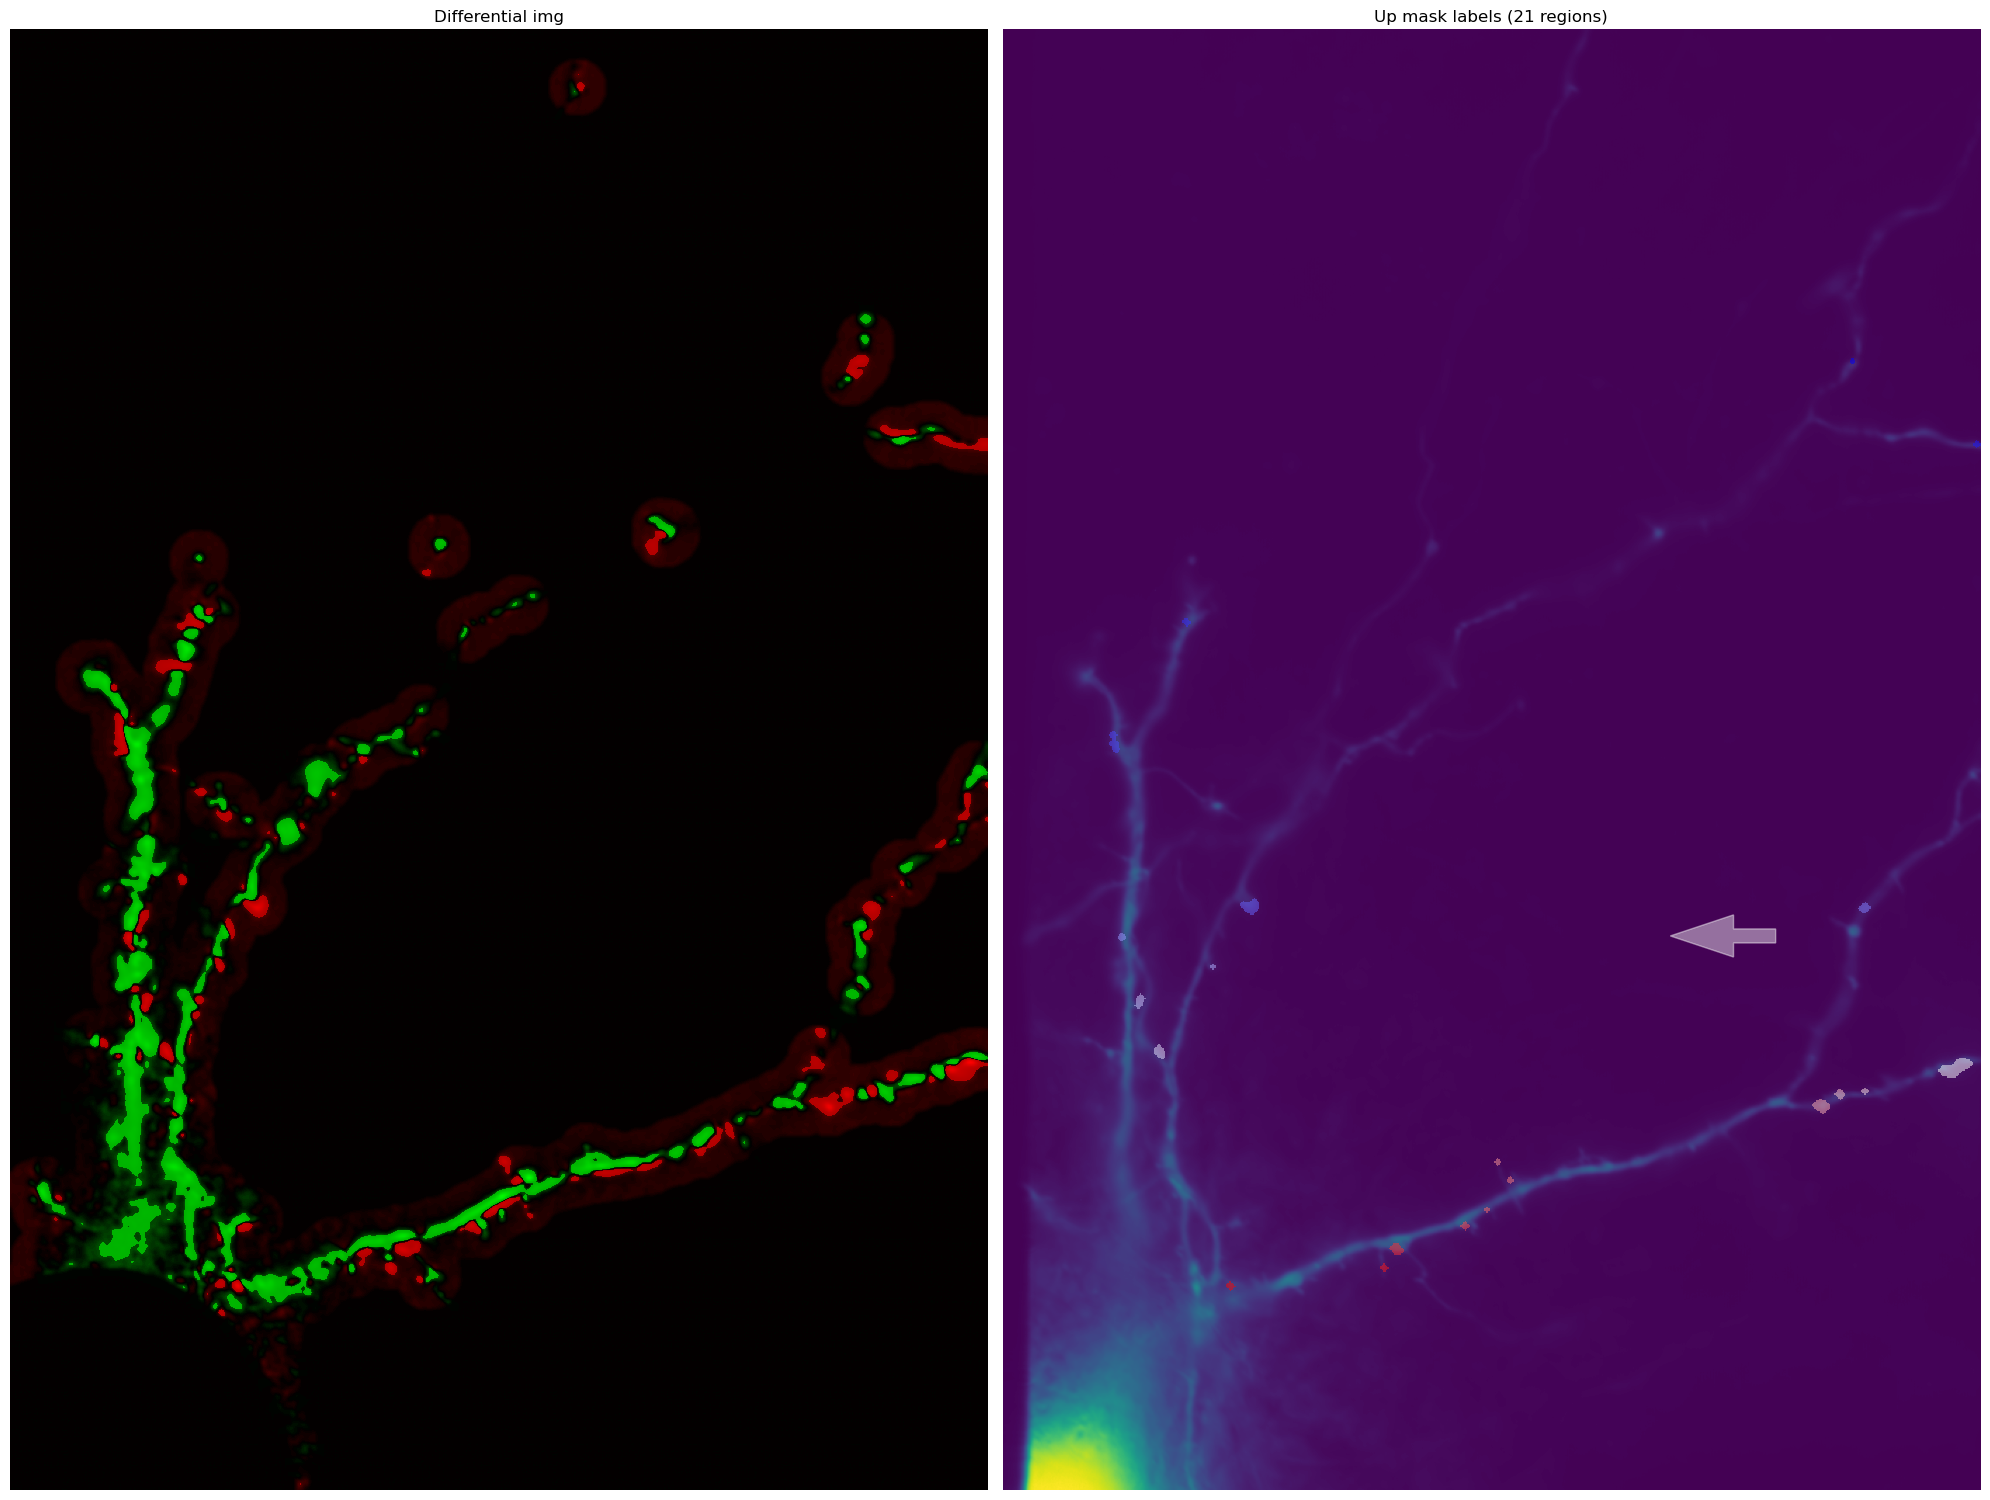

(1040, 696)
(1040, 696)


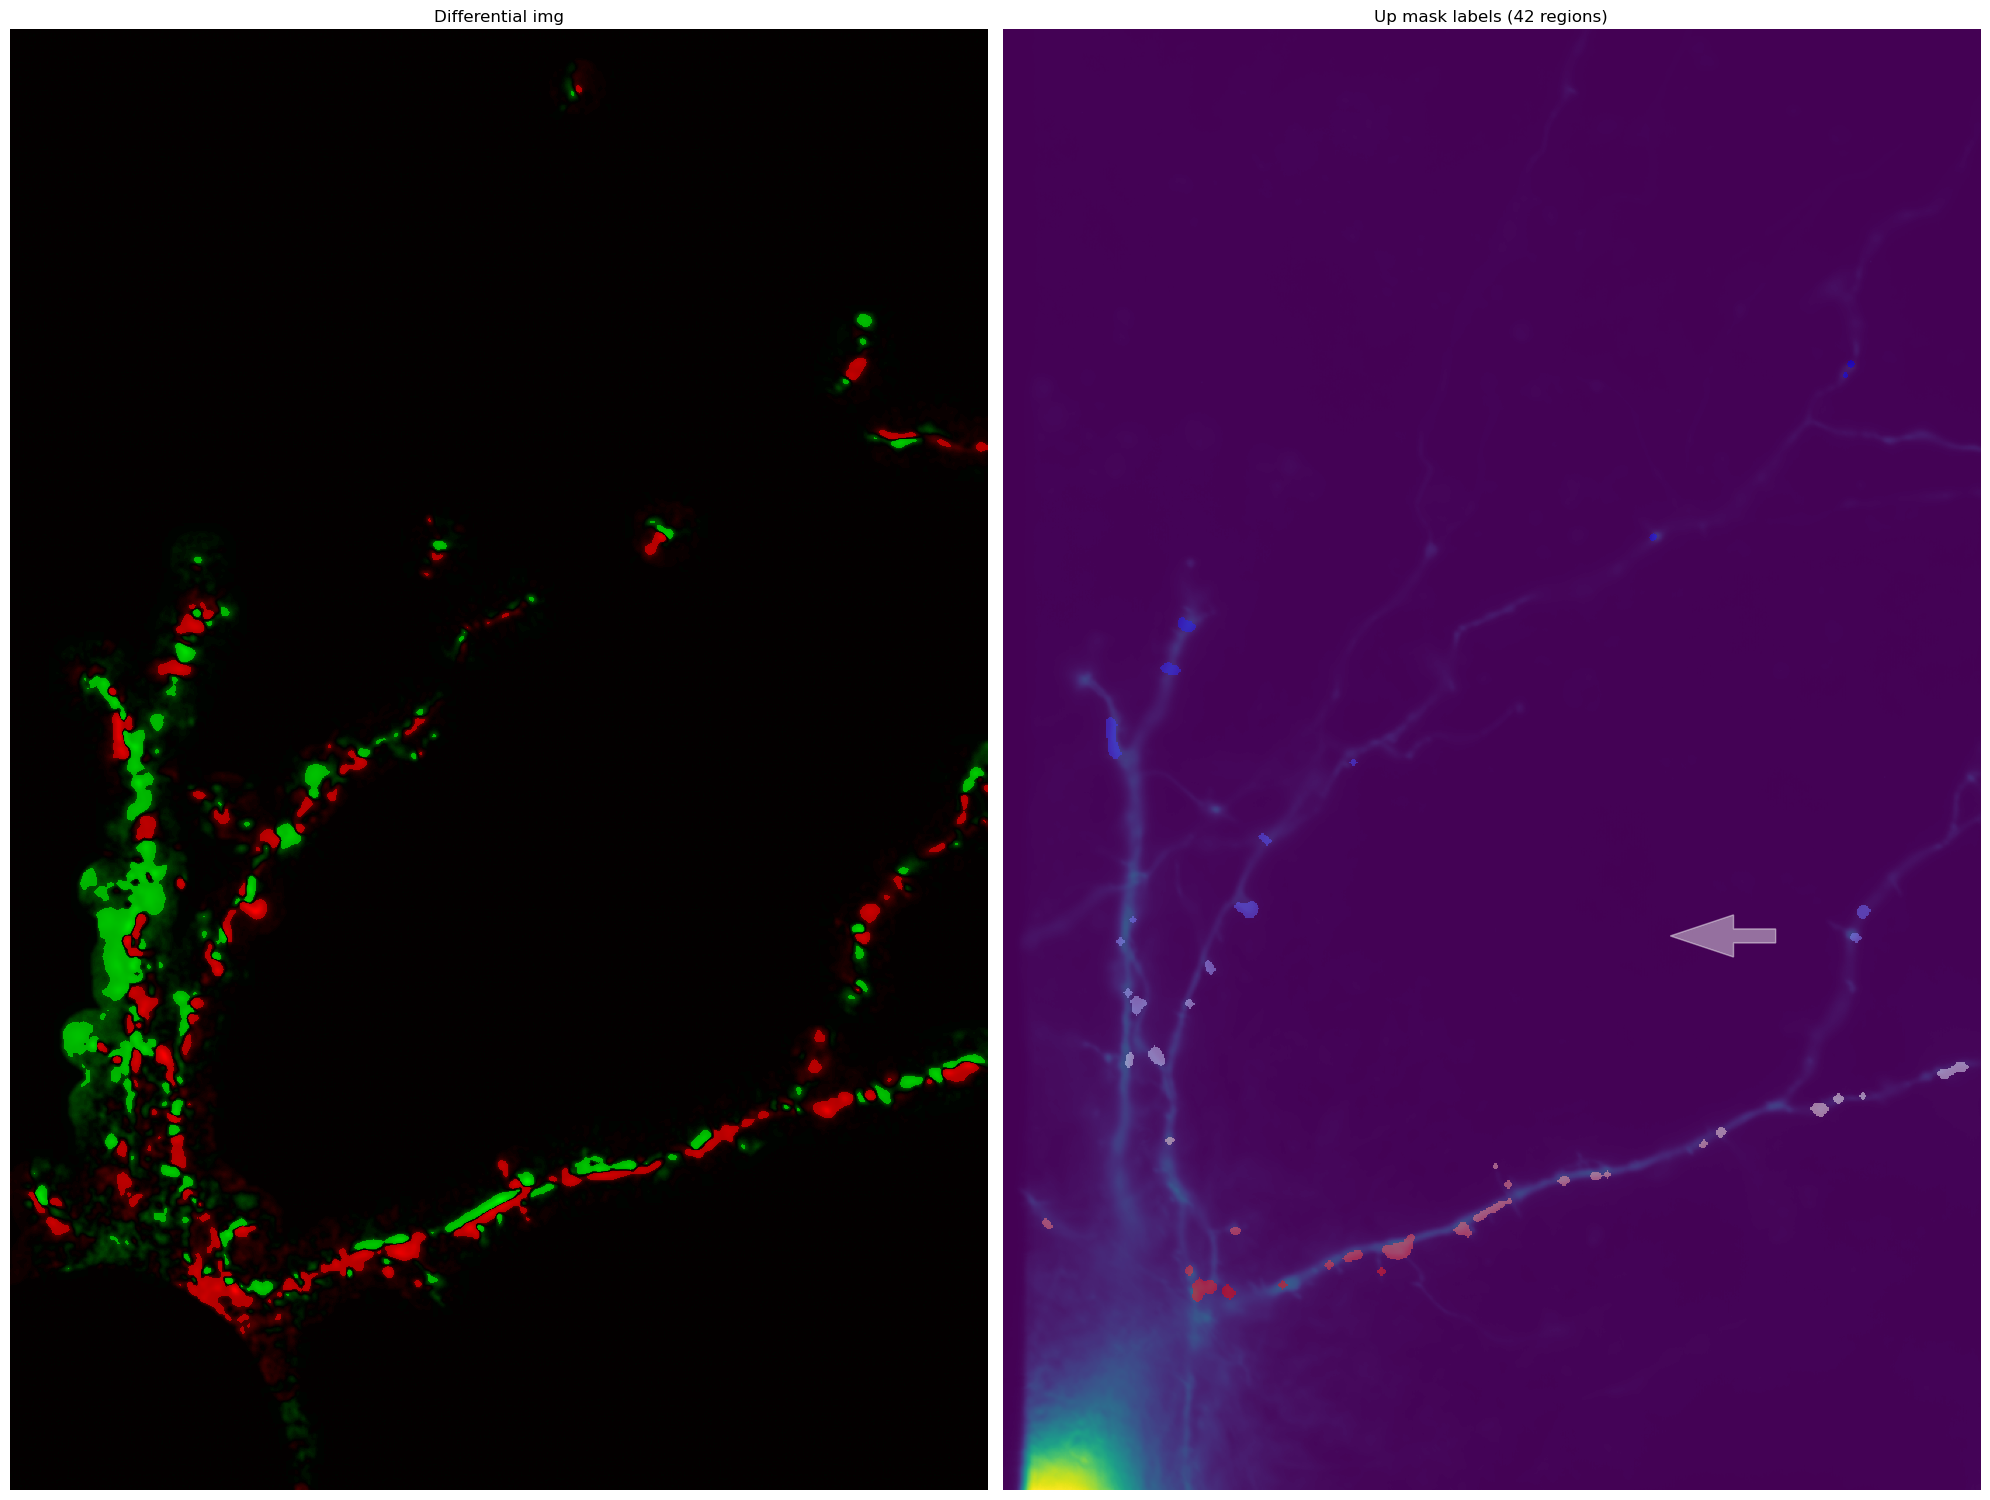

In [108]:
def up_mask_calc(input_img_series, ctrl_img, base_frames=5, app_start=7, app_win=5):

    ref_img_series = filters.gaussian(input_img_series, sigma=1.25, channel_axis=0)

    img_base = np.mean(ref_img_series[:base_frames], axis=0)
    img_max = np.mean(ref_img_series[app_start:app_start+app_win], axis=0)

    img_diff = img_max - img_base
    img_diff = img_diff/np.max(np.abs(img_diff))

    print(img_diff.shape)
    print(mask.shape)

    diff_sd = np.std(ma.masked_where(~mask, img_diff))
    up_mask = img_diff > diff_sd * 2


    up_mask_filt = morphology.opening(up_mask, footprint=morphology.disk(2))
    up_mask_filt = morphology.dilation(up_mask_filt, footprint=morphology.disk(1))
    up_label = measure.label(up_mask_filt)

    plt.figure(figsize=(20,20))
    ax0 = plt.subplot(121)
    ax0.set_title('Differential img')
    ax0.imshow(img_diff, cmap=cmap_red_green, vmax=1, vmin=-1)
    ax0.axis('off')

    ax1 = plt.subplot(122)
    ax1.set_title('Up regions')
    ax1.imshow(img_yfp_ctrl)
    ax1.imshow(ma.masked_where(~up_mask, up_mask), alpha=0.5, cmap=cmap_red)
    ax1.arrow(550,645,-30,0,width=10, alpha=0.25, color='white')
    ax1.axis('off')

    ax2 = plt.subplot(122)
    ax2.set_title(f'Up mask labels ({up_label.max()} regions)')
    ax2.imshow(ctrl_img)
    ax2.imshow(ma.masked_where(~up_mask_filt, up_label), alpha=0.5, cmap='bwr')
    ax2.arrow(550,645,-30,0,width=10, alpha=0.25, color='white')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

    return up_mask_filt, up_label

yfp_up_mask, yfp_up_label = up_mask_calc(img_yfp_masked, img_yfp_ctrl)
cfp_up_mask, cfp_up_label = up_mask_calc(img_cfp_masked, img_cfp_ctrl)

#### Up masks comparison. CFP vs. YFP

(<Figure size 988.8x604.8 with 4 Axes>,
 <AxesSubplot: >,
 <matplotlib.image.AxesImage at 0x7f49a6e6d5d0>)

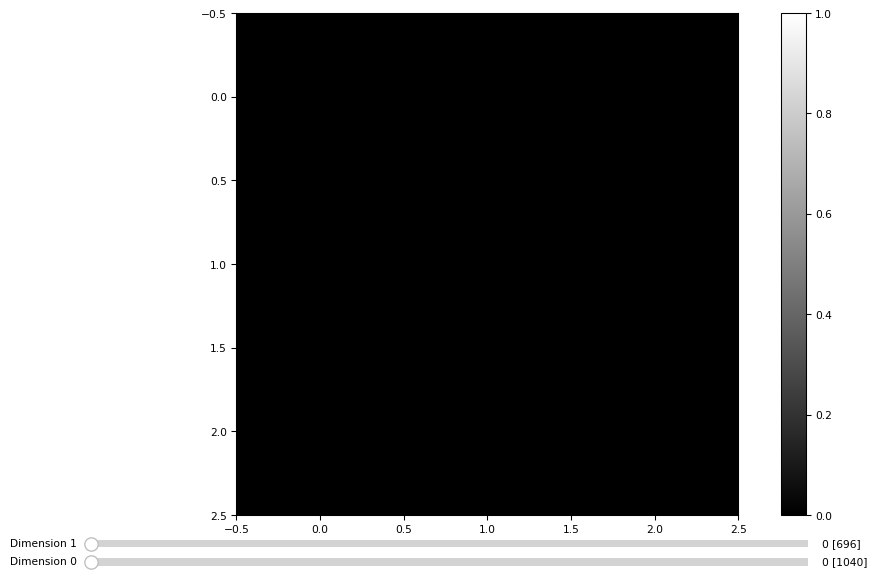

In [120]:
from skimage import color
from tifffile import imshow

mask_diff = np.stack((cfp_up_mask, yfp_up_mask, np.zeros_like(cfp_up_mask)), axis=-1)
mask_diff = color.gray2rgb(mask_diff)

# plt.figure(figsize=(20,20))
imshow(mask_diff)

#### Up mask modification

32


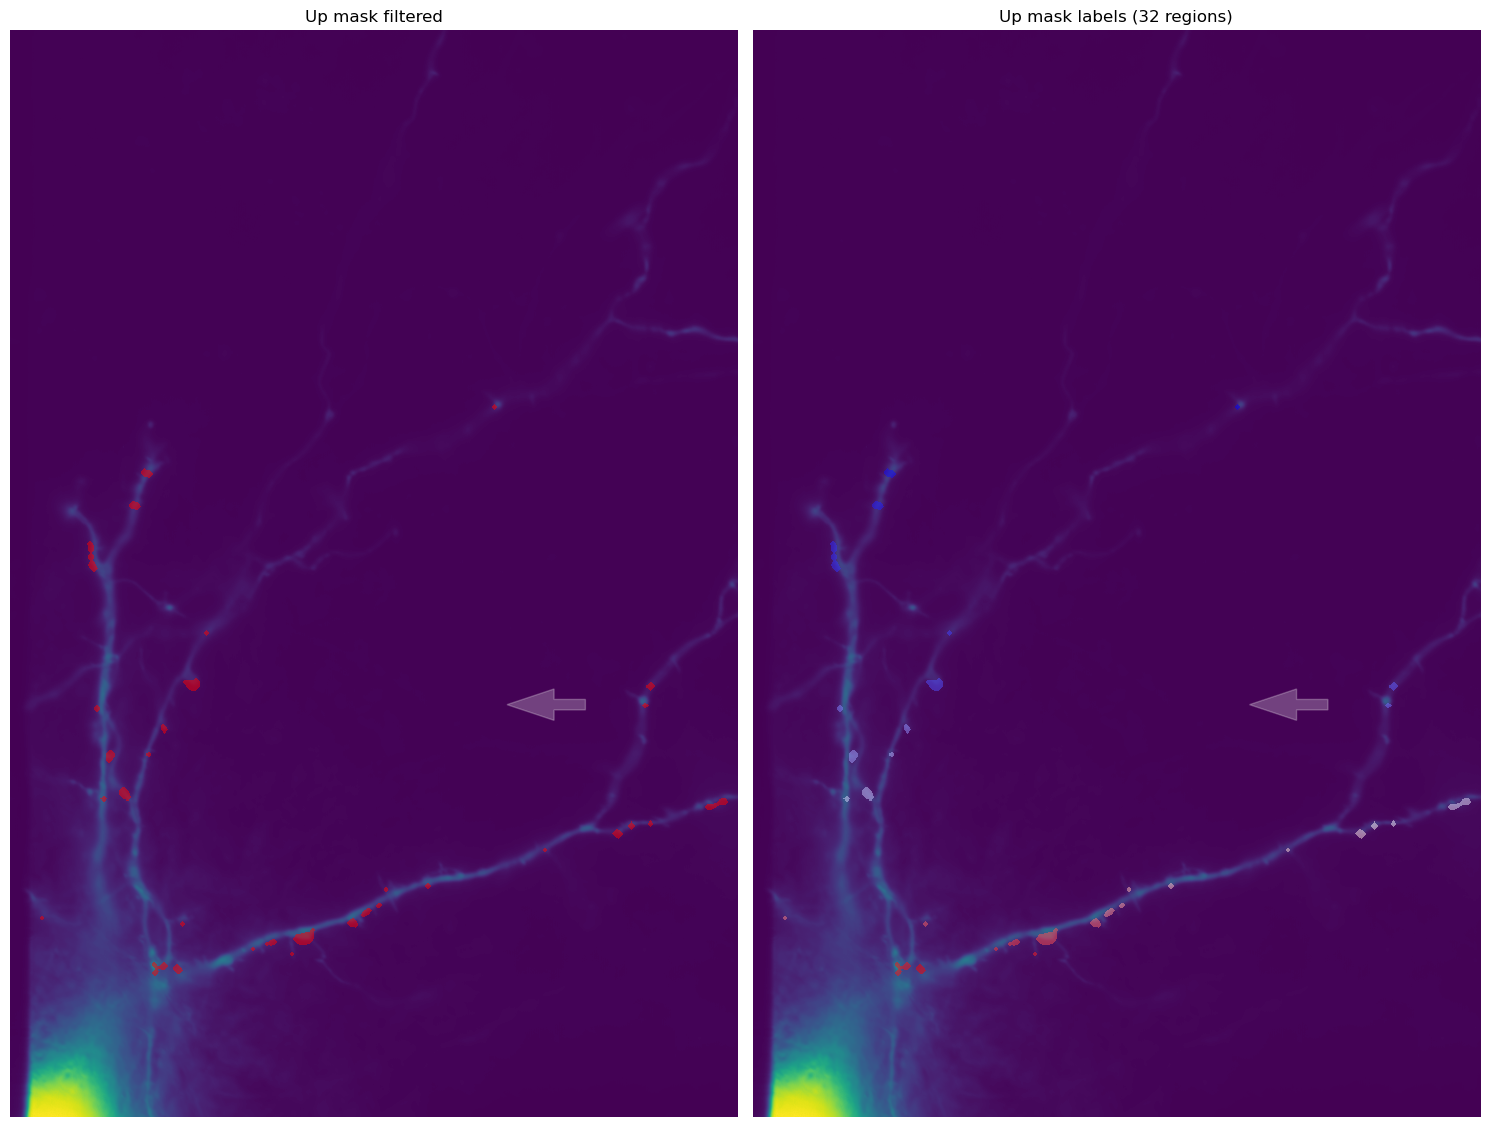

In [92]:
up_mask_filt = morphology.opening(up_mask, footprint=morphology.disk(2))
up_mask_filt = morphology.dilation(up_mask_filt, footprint=morphology.disk(1))
up_label = measure.label(up_mask_filt)

print(up_label.max())

plt.figure(figsize=(15,15))

ax1 = plt.subplot(121)
ax1.set_title('Up mask filtered')
ax1.imshow(img_yfp_ctrl)
ax1.imshow(ma.masked_where(~up_mask_filt, up_mask_filt), alpha=0.5, cmap=cmap_red)
ax1.arrow(550,645,-30,0,width=10, alpha=0.25, color='white')
ax1.axis('off')

ax1 = plt.subplot(122)
ax1.set_title(f'Up mask labels ({up_label.max()} regions)')
ax1.imshow(img_yfp_ctrl)
ax1.imshow(ma.masked_where(~up_mask_filt, up_label), alpha=0.5, cmap='bwr')
ax1.arrow(550,645,-30,0,width=10, alpha=0.25, color='white')
ax1.axis('off')

plt.tight_layout()
plt.show()

#### Up regions distance calc

In [93]:
# pipett tip position mask
pipet_mask = np.ones_like(img_yfp_ctrl)
pipet_mask[645, 480] = 0

dist_img = ndimage.distance_transform_edt(pipet_mask)
dist_img = ma.masked_where(~up_mask_filt, dist_img)


def label_prof_calc(input_labels, input_img_series, input_dist_img):
    output_dict = {}
    for label_num in range(1, np.max(input_labels)+1):
        region_mask = input_labels == label_num
        prof = np.asarray([np.mean(ma.masked_where(~region_mask, img)) for img in input_img_series])
        F_0 = np.mean(prof[:5])
        df_prof = (prof-F_0)/F_0
        dist = round(np.mean(ma.masked_where(~region_mask, input_dist_img)), 1)
        output_dict.update({dist:[label_num, prof, df_prof]})
    
    return output_dict


yfp_prof_dict = label_prof_calc(up_label, img_yfp_masked, dist_img)
cfp_prof_dict = label_prof_calc(up_label, img_cfp_masked, dist_img)

## Profile arrays creation

In [99]:
def sorted_prof_arr_calc(input_prof_dict, min_dF=0.25, mid_filter=True):
    sorted_dist = list(input_prof_dict.keys())
    sorted_dist.sort(key=float)

    prof_arr = []
    prof_id = []
    prof_dist = []
    for dist in sorted_dist:
        roi_data = input_prof_dict[dist]
        roi_id = roi_data[0]
        # roi_prof = roi_data[1]
        roi_prof_df = roi_data[2]

        if mid_filter:
            max_idx = np.argmax(roi_prof_df)
            if max_idx > len(roi_prof_df) // 3:
                continue
            
        if np.max(roi_prof_df) > min_dF:
            prof_id.append(roi_id)
            prof_arr.append(roi_prof_df)
            prof_dist.append(dist)

    prof_id = np.asarray(prof_id)
    prof_arr = np.asarray(prof_arr)
    prof_dist = np.asarray(prof_dist)

    return prof_arr

yfp_dist_prof_arr = sorted_prof_arr_calc(yfp_prof_dict, min_dF=0)
yfp_dist_prof_arr_no_filter = sorted_prof_arr_calc(yfp_prof_dict, min_dF=0, mid_filter=False)
cfp_dist_prof_arr = sorted_prof_arr_calc(cfp_prof_dict, min_dF=0)

plot_clim = 0.5

#### YFP plot

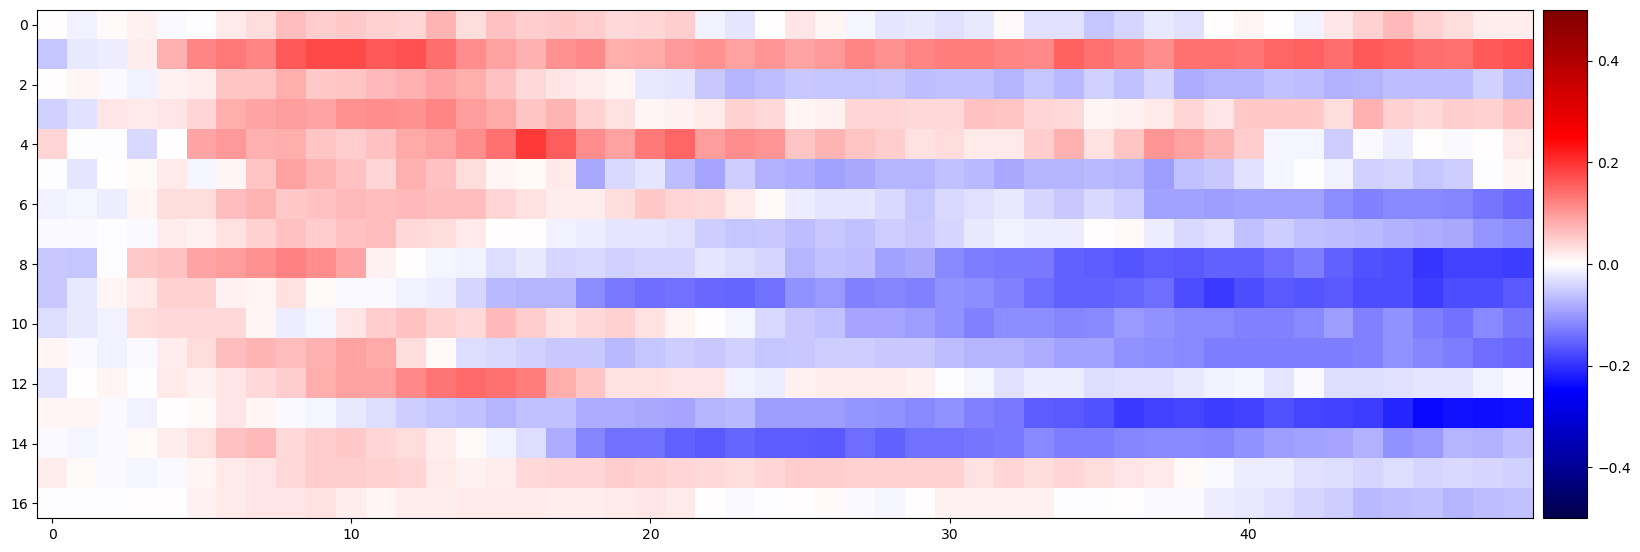

In [100]:
fig, ax = plt.subplots(figsize=(20,10))
img = ax.imshow(yfp_dist_prof_arr, cmap='seismic', aspect=1)
img.set_clim(vmin=-plot_clim, vmax=plot_clim)
div = make_axes_locatable(ax)
cax = div.append_axes('right', size='3%', pad=0.1)
plt.colorbar(img, cax=cax)
plt.show()

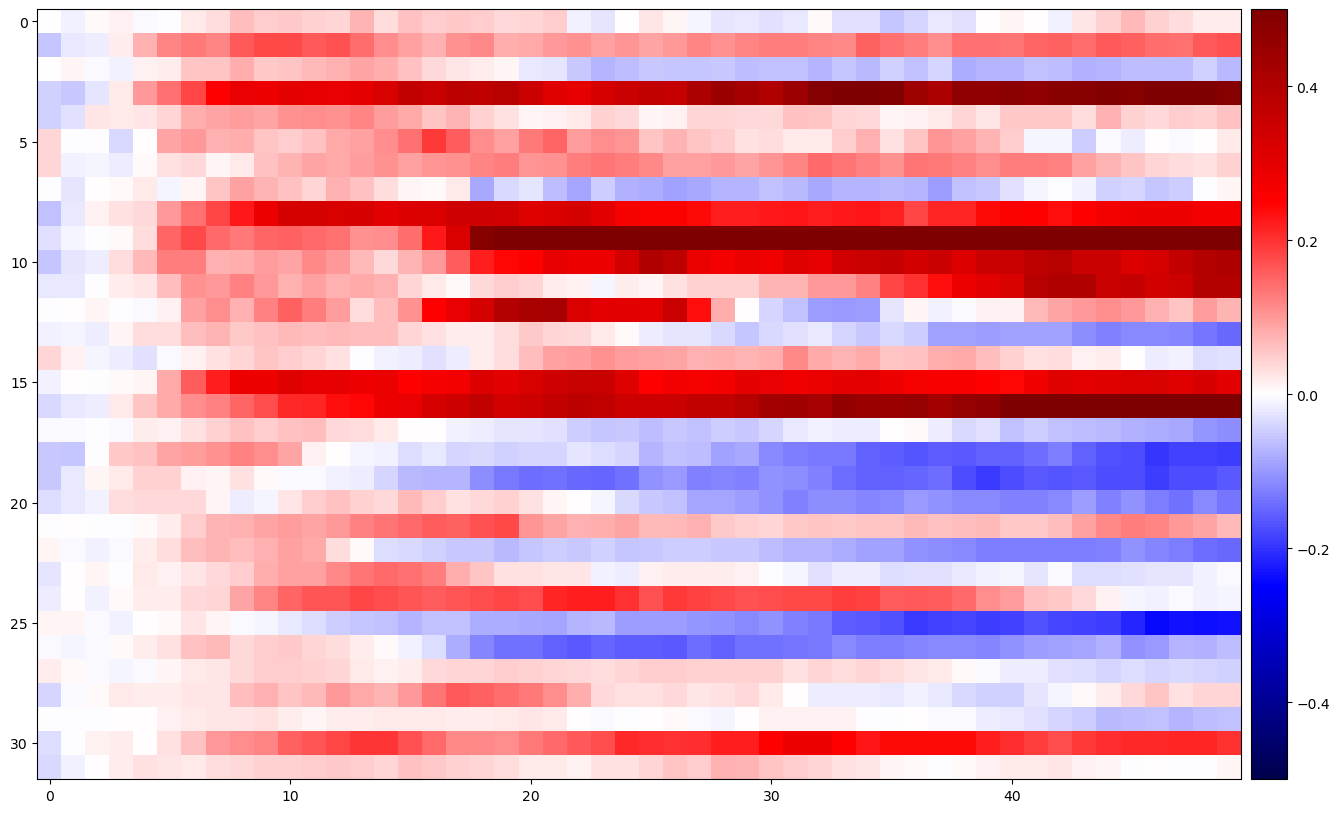

In [101]:
fig, ax = plt.subplots(figsize=(20,10))
img = ax.imshow(yfp_dist_prof_arr_no_filter, cmap='seismic', aspect=1)
img.set_clim(vmin=-plot_clim, vmax=plot_clim)
div = make_axes_locatable(ax)
cax = div.append_axes('right', size='3%', pad=0.1)
plt.colorbar(img, cax=cax)
plt.show()

#### CFP plot

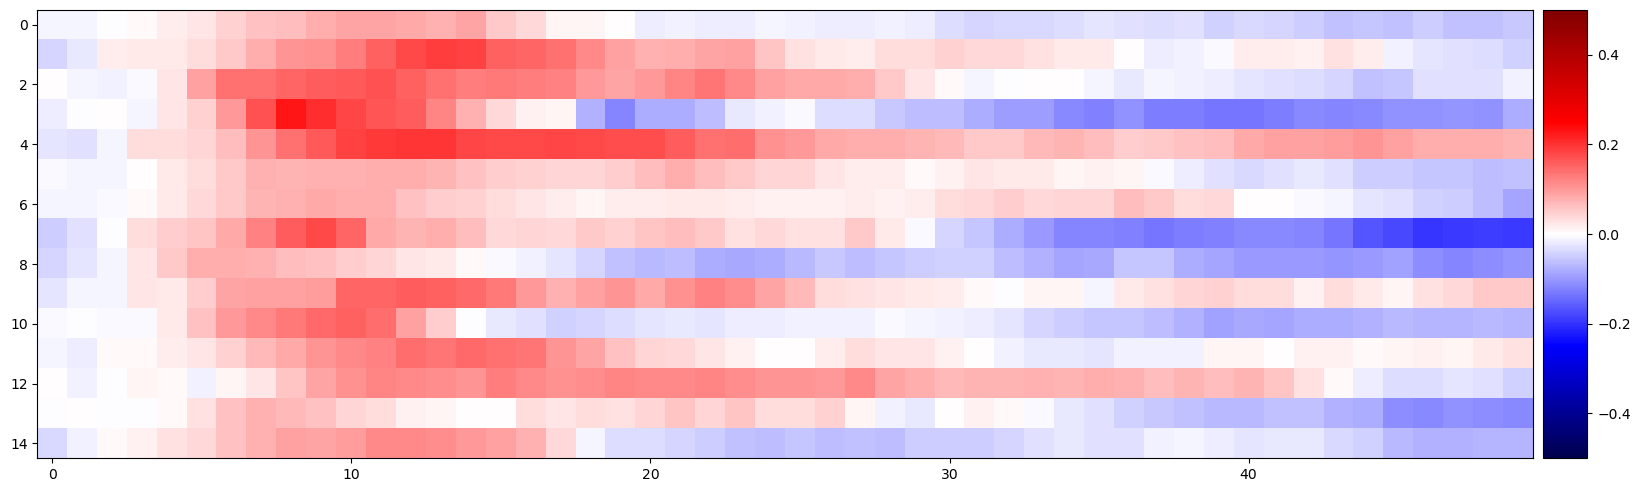

In [102]:
cfp_clim = 0.75

fig, ax = plt.subplots(figsize=(20,20))
img = ax.imshow(cfp_dist_prof_arr, cmap='seismic', aspect = 1)
img.set_clim(vmin=-plot_clim, vmax=plot_clim)
div = make_axes_locatable(ax)
cax = div.append_axes('right', size='3%', pad=0.1)
plt.colorbar(img, cax=cax)
plt.show()

## Stat

#### Maximal amplitude extraction

In [103]:
yfp_max_amp = np.max(yfp_dist_prof_arr, axis=1)
cfp_max_amp = np.max(cfp_dist_prof_arr, axis=1)

print(len(yfp_max_amp))
print(len(cfp_max_amp))

u_test = stats.mannwhitneyu(yfp_max_amp, cfp_max_amp)
print(f"U-test p-val={round(u_test[1], 5)}")

17
15
U-test p-val=0.00917


#### Amplitude box-plot

In [104]:
yfp_amp_df = pd.DataFrame({'FP':np.full(len(yfp_max_amp), 'YFP'),
                           'amp':yfp_max_amp})
cfp_amp_df = pd.DataFrame({'FP':np.full(len(cfp_max_amp), 'CFP'),
                           'amp':cfp_max_amp})
amp_df = pd.concat([yfp_amp_df, cfp_amp_df], ignore_index=True)

fig = px.box(amp_df, x='FP', y='amp', color='FP', points='all', title=f'Maximal dF/F per ROI, U-test p={round(u_test[1], 5)}')
fig.show()